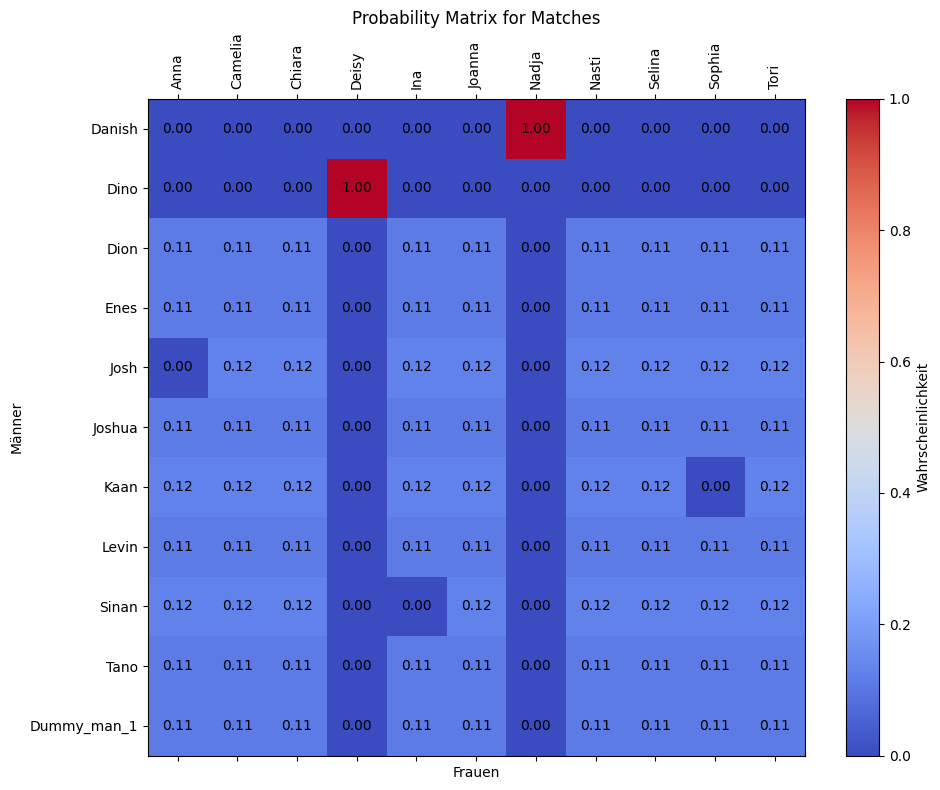


Häufigkeit der Paare (über alle Match Ceremonies):
Dino - Deisy: 7 mal
Joshua - Joanna: 5 mal
Tano - Tori: 5 mal
Levin - Camelia: 4 mal
Enes - Selina: 4 mal
Danish - Nadja: 4 mal
Josh - Nadja: 3 mal
Kaan - Anna: 3 mal
Levin - Chiara: 3 mal
Sinan - Nasti: 3 mal
Sinan - Ina: 2 mal
Dion - Tori: 2 mal
Danish - Sophia: 2 mal
Dion - Chiara: 2 mal
Josh - Ina: 2 mal
Kaan - Sophia: 2 mal
Kaan - Joanna: 1 mal
Enes - Anna: 1 mal
Joshua - Selina: 1 mal
Tano - Chiara: 1 mal
Dion - Selina: 1 mal
Enes - Nasti: 1 mal
Danish - Camelia: 1 mal
Sinan - Sophia: 1 mal
Dion - Nasti: 1 mal
Dion - Anna: 1 mal
Josh - Nasti: 1 mal
Sinan - Camelia: 1 mal
Joshua - Ina: 1 mal
Tano - Anna: 1 mal
Josh - Camelia: 1 mal
Kaan - Selina: 1 mal
Enes - Sophia: 1 mal


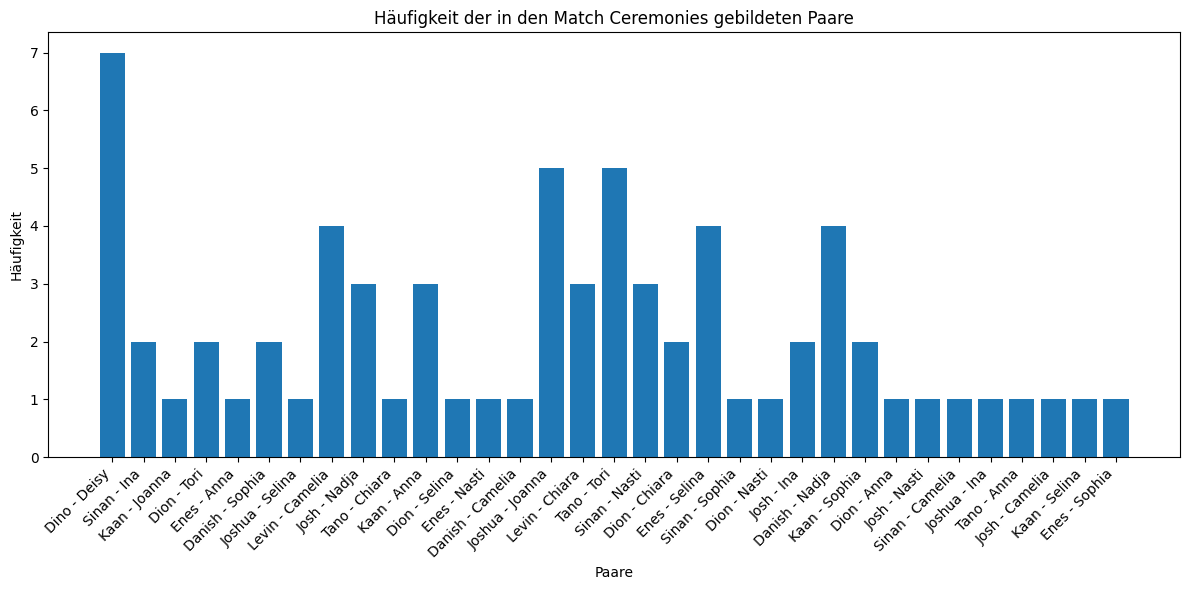

Frontier: 1 | Complete: 153015: 100%|█████████▉| 518602/518603 [06:13<00:00, 1388.65it/s]    


Das durch A*-Suche gefundene optimale Matching ist:
Danish - Nadja | Dino - Deisy | Dion - Anna | Dummy_man_1 - Tori | Enes - Chiara | Josh - Camelia | Joshua - Nasti | Kaan - Selina | Levin - Ina | Sinan - Joanna | Tano - Sophia | 
Gesamtkosten: 10

Anzahl aller vollständigen Lösungen: 153015


In [ ]:
import heapq
import copy
import itertools
from tqdm import tqdm
import numpy as np
from data_preprocessing import preprocessing, DUMMY_PENALTY

SEASON = "Season_6.json"
HUGE_PENALTY = 10     # sehr hoher Strafwert für Regelverletzungen

def check_constraints(state, confirmed, fixed, probabilities, ceremonies):
    """
    Prüft für einen gegebenen Zustand (state) alle Constraints:
      1. Alle perfekten Matches (confirmed) müssen vorhanden sein.
      2. Ausgeschlossene Paarungen (fixed True und probability == 0) dürfen nicht vorkommen.
      3. Für jede Ceremony muss die Anzahl der gemeinsamen Paare mit der matching_night 
         (repräsentiert durch ceremony['score']) exakt stimmen.
    Gibt bei einer Verletzung einen hohen Strafwert zurück.
    """
    for man, woman in confirmed.items():
        if state.get(man) != woman:
            return HUGE_PENALTY
        
    for man, woman in state.items():
        if fixed.get((man, woman), False) and probabilities.get((man, woman), 0) == 0:
            return HUGE_PENALTY
        
    candidate_pairs = {(man, state[man]) for man in state}
    for ceremony in ceremonies:
        ceremony_pairs = {(p['man'].lower(), p['woman'].lower()) for p in ceremony['pairs']}
        observed = ceremony['score']
        common = len(candidate_pairs & ceremony_pairs)
        if common != observed:
            return HUGE_PENALTY * abs(common - observed)
        
    return 0

def evaluate_matching(candidate, ceremonies, confirmed, fixed, probabilities):
    """
    Bewertet ein vollständiges Matching (candidate).
    Zuerst wird check_constraints aufgerufen.
    Falls ein Constraint verletzt ist, wird ein hoher Strafwert zurückgegeben.
    """
    penalty = check_constraints(candidate, confirmed, fixed, probabilities, ceremonies)
    if penalty > 0:
        return penalty
    return 0

def partial_cost(state, ceremonies):
    cost = 0
    candidate_pairs = {(man, state[man]) for man in state}
    for ceremony in ceremonies:
        ceremony_pairs = {(p['man'].lower(), p['woman'].lower()) for p in ceremony['pairs']}
        observed = ceremony['score']
        current_matches = sum(
            1 for (man, woman) in candidate_pairs
            if not man.startswith("dummy") and not woman.startswith("dummy") and (man, woman) in ceremony_pairs
        )
        if current_matches > observed:
            cost += (current_matches - observed)
    for man, woman in state.items():
        if man.startswith("dummy") or woman.startswith("dummy"):
            cost += DUMMY_PENALTY
    return cost

def heuristic(state, ceremonies, remaining_count):
    h = 0
    candidate_pairs = {(man, state[man]) for man in state}
    for ceremony in ceremonies:
        ceremony_pairs = {(p['man'].lower(), p['woman'].lower()) for p in ceremony['pairs']}
        observed = ceremony['score']
        current_matches = sum(
            1 for (man, woman) in candidate_pairs
            if not man.startswith("dummy") and not woman.startswith("dummy") and (man, woman) in ceremony_pairs
        )
        if current_matches >= observed:
            h += (current_matches - observed)
        else:
            best_possible = current_matches + remaining_count
            h += max(0, observed - best_possible)
    return h

def a_star_search(confirmed, variable_men, participants, fixed, ceremonies, probabilities):
    """
    Führt A*-Suche durch, um alle vollständigen Matchings zu finden.
    Es werden alle vollständigen Zustände in complete_solutions gespeichert.
    Ein Fortschrittsbalken (tqdm) zeigt an, wie viele Knoten bereits verarbeitet wurden 
    und wie viele vollständige Lösungen gefunden wurden.
    """
    counter = itertools.count()
    initial_state = confirmed.copy()
    initial_remaining = variable_men.copy()
    g = partial_cost(initial_state, ceremonies)
    h = heuristic(initial_state, ceremonies, len(initial_remaining))
    f = g + h
    frontier = [(f, g, next(counter), initial_state, initial_remaining)]
    
    complete_solutions = []  # Liste aller vollständigen Zustände (Matching, cost)
    best_complete = None
    best_complete_cost = float('inf')
    
    # Wir nutzen tqdm, um den Fortschritt anzuzeigen. Da wir die Gesamtanzahl nicht kennen,
    # aktualisieren wir den Fortschritt dynamisch.
    progress = tqdm(total=0, dynamic_ncols=True)
    iterations = 0
    
    while frontier:
        iterations += 1
        progress.total = iterations + len(frontier)
        progress.update(1)
        progress.set_description(f"Frontier: {len(frontier)} | Complete: {len(complete_solutions)}")
        
        f, g, _, state, remaining = heapq.heappop(frontier)
        # Branch and Bound: Wenn f >= best_complete_cost, diesen Zweig verwerfen.
        if f >= best_complete_cost:
            continue
        
        if not remaining:
            total_cost = evaluate_matching(state, ceremonies, confirmed, fixed, probabilities)
            complete_solutions.append((state, total_cost))
            if total_cost < best_complete_cost:
                best_complete_cost = total_cost
                best_complete = state
            continue
        
        next_man = remaining[0]
        new_remaining = remaining[1:]
        used_women = set(state.values())
        allowed = [w for w in participants['women'] if w not in used_women and not fixed.get((next_man, w), False)]
        for woman in allowed:
            new_state = state.copy()
            new_state[next_man] = woman
            new_g = partial_cost(new_state, ceremonies)
            new_h = heuristic(new_state, ceremonies, len(new_remaining))
            new_f = new_g + new_h
            if new_f >= best_complete_cost:
                continue
            heapq.heappush(frontier, (new_f, new_g, next(counter), new_state, new_remaining))
    progress.close()
    return best_complete, best_complete_cost, complete_solutions


if __name__ == "__main__":
    # Preprocessing durchführen und Daten laden
    season = SEASON
    probabilities, fixed, participants, ceremonies = preprocessing(season)
    
    # Ermittlung der fixierten (confirmed) Paare: Diese müssen in jedem Matching enthalten sein.
    confirmed = {}
    for man in participants['men']:
        for woman in participants['women']:
            if fixed.get((man, woman), False) and probabilities.get((man, woman), 0) == 1.0:
                confirmed[man] = woman
                break
    variable_men = [man for man in participants['men'] if man not in confirmed]
    
    best_matching, best_cost, complete_solutions = a_star_search(confirmed, variable_men, participants, fixed, ceremonies, probabilities)
    
    if best_matching is not None:
        print("\nDas durch A*-Suche gefundene optimale Matching ist:")
        for man, woman in sorted(best_matching.items()):
            print(f"{man.capitalize()} - {woman.capitalize()}")
        print(f"\nGesamtkosten: {best_cost}")
    else:
        print("Kein vollständiges Matching gefunden.")
    
    print(f"\nAnzahl aller vollständigen Lösungen: {len(complete_solutions)}")